In [60]:
import os
from pathlib import Path
from typing import Callable
import warnings

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from segregation.aspatial import MinMax, Dissim
import rasterio as rio
from scipy.spatial.distance import cdist


data_dir = Path('../data')

In [61]:
def get_xy(
        geodf: gpd.GeoDataFrame,
        geometry_col: str = None,
) -> gpd.GeoDataFrame:

    if not geometry_col:
        geometry_col = geodf.geometry.name

    if geodf[geometry_col].geom_type[0] == 'Point':
        geodf['x'] = geodf[geometry_col].apply(lambda geom: geom.x)
        geodf['y'] = geodf[geometry_col].apply(lambda geom: geom.y)
    else:
        geodf['x'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[0]))
        geodf['y'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[1]))
    return geodf


def kernel_density_surface(
        data: gpd.GeoDataFrame,
        group: str,
        bandwidth,
        cell_size,
        kernel_function: Callable,
):
    pop = get_xy(data)
    pad = bandwidth * 2

    minx, miny, maxx, maxy = pop.geometry.total_bounds

    minx -= pad
    miny -= pad
    maxx += pad
    maxy += pad

    x = np.arange(minx, maxx, cell_size)
    y = np.arange(miny, maxy, cell_size)

    X, Y = np.meshgrid(x, y)

    xy = np.vstack([Y.ravel(), X.ravel()]).T

    U = cdist(xy, pop[['y', 'x']].values, metric='euclidean')
    W = kernel_function(U, bandwidth=bandwidth)

    density = (W * pop[group].values).sum(axis=1).reshape(X.shape)

    geotiff_meta = {
        'driver': 'GTiff',
        'count': 1,
        'dtype': 'float64',
        'width': len(x),
        'height': len(y),
        'crs': data.crs,
        'transform': rio.transform.from_bounds(
            west=minx,
            east=maxx,
            north=maxy,
            south=miny,
            width=len(x),
            height=len(y),
        )
    }

    return density[::-1, ], geotiff_meta


def get_S(
        data,
        bandwidth,
        cell_size,
        kernel_function,
):
    if data.empty:
        return None

    density_total, _ = kernel_density_surface(
        data,
        group='total',
        bandwidth=bandwidth,
        cell_size=cell_size,
        kernel_function=kernel_function,
    )
    density_orthodox, _ = kernel_density_surface(
        data,
        group='orthodox',
        bandwidth=bandwidth,
        cell_size=cell_size,
        kernel_function=kernel_function,
    )

    density = pd.DataFrame({
            'orthodox': density_orthodox.flatten(),
            'total': density_total.flatten(),
         })
    S = MinMax(density, 'orthodox', 'total')

    return S


In [70]:

def remove_institutions(
        pop_data: pd.DataFrame,
        institutions: pd.DataFrame,
        year,
):
    institutions = institutions.set_index(['district', 'plot_number'])
    institutions = institutions.loc[institutions.year == year]
    pop_data = pop_data.drop(index=institutions.index, errors='ignore')
    return pop_data


def prepare_pop_data(
        population_data: pd.DataFrame,
        num_cols=None,
) -> pd.DataFrame:

    pop_frame = population_data.fillna(value=0)

    if not num_cols:
        num_cols = [
            'total_men',
            'total_women',
            'orthodox',
            'other_christian',
            'other_religion',
        ]

    pop_frame.loc[:, num_cols] = pop_frame.loc[:, num_cols].astype(int)

    pop_frame['lutheran'] = pop_frame['total_men total_women'.split()].sum(axis=1) \
                            - pop_frame['other_christian orthodox other_religion'.split()].sum(axis=1)

    pop_frame['total'] = pop_frame['other_christian orthodox other_religion lutheran'.split()].sum(axis=1)

    return pop_frame

In [63]:
def split_plots(
        geodataframe: gpd.GeoDataFrame,
        target_col: str,
        separator: str = ',',
) -> gpd.GeoDataFrame:

    new_geodataframe = gpd.GeoDataFrame(columns=geodataframe.columns)

    for _, row in geodataframe.iterrows():
        plots = str(row[target_col]).split(separator)

        if len(plots) < 2:
            new_geodataframe = new_geodataframe.append(row)
            continue

        for plot in plots:
            new_row = row
            new_row[target_col] = plot
            new_geodataframe = new_geodataframe.append(new_row)

    assert len(new_geodataframe.index) == len(list(pd.core.common.flatten(
        [
            str(w).split(separator)
            for w
            in geodataframe[target_col]
        ]))), 'splitting failed'

    return new_geodataframe.reindex()


In [64]:
def quartic_kernel(u, bandwidth):
    return np.where(
            np.abs(u) <= bandwidth,
            3 / (np.pi * bandwidth * bandwidth) * (1 - (u / bandwidth) ** 2) ** 2,
            0
    )

            district page_number representative_plot  taxpayer_men  \
0              Valli           1                   3          11.0   
1              Valli           2                   8          13.0   
2              Valli           3                  11          22.0   
3              Valli           4                  15          12.0   
4              Valli           5                  19          21.0   
..               ...         ...                 ...           ...   
168          Sorvali         168                  24           1.0   
169    Kolikkoinmäki         169                   4          24.0   
170    Kolikkoinmäki         170                   7          13.0   
171  Viipurin_pitäjä         171                   7          14.0   
172  Viipurin_pitäjä         172                   7           0.0   

     taxpayer_women  no_tax_men  no_tax_women  in_russia_men  in_russia_women  \
0              19.0         8.0           8.0            0.0              0.0 

<AxesSubplot:>

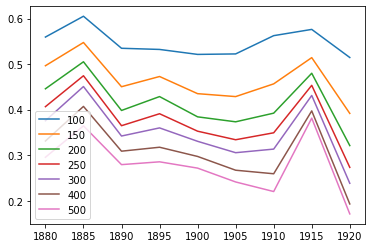

In [71]:
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(data_dir / 'institutions.csv')

location_data = gpd.read_file(data_dir / 'raw' / 'plots_1878.shp').to_crs(epsg=3067)
location_data = split_plots(location_data, target_col='NUMBER')
location_data['district'] = [district_codes[int(d)] for d in location_data['DISTRICT']]
location_data['plot_number'] = [str(i) for i in location_data['NUMBER']]
location_data = location_data.set_index(['district', 'plot_number'])
city = gpd.read_file(data_dir / 'raw' / 'city_1846.shp').to_crs(epsg=3067)
location_data = location_data.loc[~location_data.geometry.within(city.geometry[0]).index.duplicated()]
location_data = location_data.loc[location_data.geometry.within(city.geometry[0])]

results = {}
bws = 100, 150, 200, 250, 300, 400, 500

for year in range(1880, 1921, 5):
    s_ = []

    for bw in bws:
        population_data = pd.read_csv(
            data_dir / 'interim' / f'pop_by_page_{year}.csv',
            index_col=0,
            dtype={'district': str, 'representative_plot': str, 'page_number': str},
        ).pipe(prepare_pop_data)
        print(population_data)
        print(population_data.pipe(remove_institutions, institutions, year))

        population_data.rename({'representative_plot': 'plot_number'}, axis=1, inplace=True)
        population_data = population_data.set_index(['district', 'plot_number'], drop=True)

        page_location_data = location_data.join(population_data, on=['district', 'plot_number'])
        page_location_data.dropna(axis=0, inplace=True)

        S = get_S(
            data=page_location_data,
            bandwidth=bw,
            cell_size=25,
            kernel_function=quartic_kernel,
        )

        s_.append(S.statistic)

    results[year] = s_

results = pd.DataFrame.from_dict(
    results,
    orient='index',
    columns=bws,
)
print(results)
results.plot()

In [ ]:
districts_in_city = [
    'Valli',
    'Salakkalahti',
    'Repola',
    'Anina',
    'Papula',
    'P_Annan_kruunu',
    'Hiekka',
    'Pantsarlahti',
    'Viipurin_esikaupunki',
    'Paulovski',
    'Havi',
    'Saunalahti',
    'Pietarin_esikaupunki',
]

results = {}

for year in range(1880, 1921, 5):
    population_data = pd.read_csv(
            data_dir / 'interim' / f'pop_by_page_{year}.csv',
            index_col=0,
            dtype={'district': str, 'representative_plot': str, 'page_number': str},
        ).pipe(prepare_pop_data)
    population_data = population_data[population_data.district.isin(districts_in_city)]

    D = Dissim(
        population_data,
        group_pop_var='orthodox',
        total_pop_var='total',
    )
    results[year] = D.statistic

    print(population_data.loc[:, ['district', 'lutheran', 'orthodox']].groupby('district').sum())

results = pd.Series(results)
results.plot()